In [233]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')
plt.style.use('seaborn')

For more info about Adaboost and Gradient Boosting, read [here](https://towardsdatascience.com/basic-ensemble-learning-random-forest-adaboost-gradient-boosting-step-by-step-explained-95d49d1e2725)

## Feature Engineering

In [112]:
PATH = '/Users/dhyungseoklee/Projects/data/'
df = pd.read_excel(PATH + 'energy_data.xlsx')
df.columns = [['relative compactness','surface area','wall area','roof area','overall height',
               'orientation','glazing area','glazing area distribution','heating load',
               'cooling load']]

In [113]:
df.head()

,relative compactness,surface area,wall area,roof area,overall height,orientation,glazing area,glazing area distribution,heating load,cooling load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


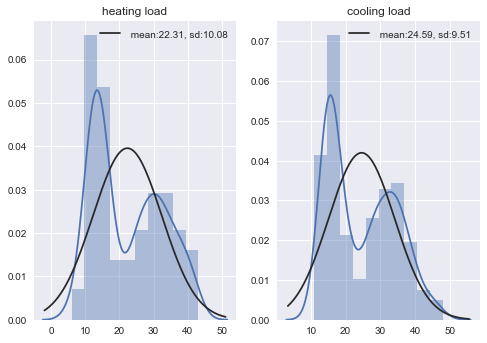

In [114]:
# checking normality of target variable
from scipy import stats
import seaborn as sns

plt.subplot(121)
target1 = df['heating load']
(mu, sigma) = stats.norm.fit(target1)
sns.distplot(target1, fit = stats.norm)
plt.title('heating load')
plt.legend([f''' mean:{mu:.2f}, sd:{sigma:.2f}'''], loc = 'best' )

plt.subplot(122)
target2 = df['cooling load']
(mu1, sigma1) = stats.norm.fit(target2)
sns.distplot(target2, fit = stats.norm)
plt.title('cooling load')
plt.legend([f''' mean:{mu1:.2f}, sd:{sigma1:.2f}'''], loc = 'best')

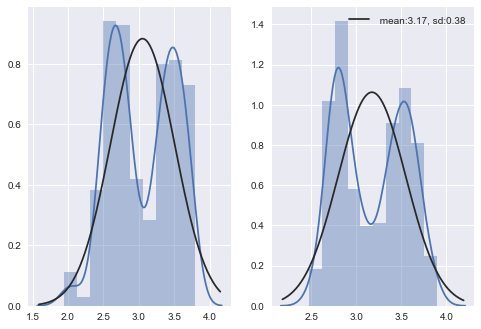

In [115]:
# transform target variables to normal distribution to better fit the model
target1_nd = np.log1p(target1)
target2_nd = np.log1p(target2)
# check the distribution
fig, ax = plt.subplots(1,2)
(mu, sigma) = stats.norm.fit(target1_nd)
sns.distplot(target1_nd, fit = stats.norm, ax = ax[0])
plt.legend([f''' mean:{mu:.2f}, sd:{sigma:.2f}'''], loc = 'best')

(mu1, sigma1) = stats.norm.fit(target2_nd)
sns.distplot(target2_nd, fit= stats.norm, ax = ax[1])
plt.legend([f''' mean:{mu1:.2f}, sd:{sigma1:.2f}'''], loc = 'best')

In [116]:
# check skewness of feature variables 
skew_index = df.dtypes[df.dtypes != 'object'].index
skew_data = df[skew_index].drop(columns = ['heating load', 'cooling load'])
skew_measure = skew_data.apply(lambda x: stats.skew(x.dropna())).sort_values(ascending = False)
skew_measure = pd.DataFrame(skew_measure)
skew_measure.head()

,0
wall area,0.532375
relative compactness,0.494544
orientation,0.000000
overall height,0.000000
glazing area,-0.060136


every feature variable is barely skewed so we don't need to worry about it

In [118]:
# check if there is any missing value
missing_value = (df.isnull().sum()/len(df))*100
missing_value = missing_value.to_frame()
missing_value

,0
relative compactness,0.0
surface area,0.0
wall area,0.0
roof area,0.0
overall height,0.0
orientation,0.0
glazing area,0.0
glazing area distribution,0.0
heating load,0.0
cooling load,0.0


In [302]:
# scaling data and splitting it to train test
from sklearn.preprocessing import MinMaxScaler
X = df.iloc[:, :8].values
y = pd.concat((target1_nd, target2_nd), axis = 1).values

sc = MinMaxScaler(feature_range = (0,1))
X = sc.fit_transform(X)

# train test split
split = round(df.shape[0]*0.8)
X_train, y_train = X[:split, :], y[:split, :]
X_test, y_test = X[split:, :], y[split:, :]

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(614, 8) (154, 8) (614, 2) (154, 2)


## Regression Modeling

In [303]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor  # to wrap around the models that do not handle multiple target variables
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [304]:
# testing regression models with KFold K = 10
models = []
models.append(('LR', LinearRegression()))
models.append(('Poly', LinearRegression()))
models.append(('SVR', SVR()))
models.append(('DT', DecisionTreeRegressor()))
models.append(('RF',RandomForestRegressor()))
models.append(('Ada', AdaBoostRegressor(n_estimators = 50)))
models.append(('Gradient', GradientBoostingRegressor(n_estimators = 50)))
models.append(('Xgboost', XGBRegressor(n_estimators = 50, objective = 'reg:squarederror')))
models.append(('LGBM', LGBMRegressor(n_estimators = 50)))

features = X
targets = y

for name, model in models:
    if name in ('LR','Poly','DT','RF'):
        if name in ('Poly'):
            poly_reg = PolynomialFeatures(degree = 2)
            poly_x = poly_reg.fit_transform(features)
            model = model
            k_score = cross_val_score(model, features, targets, cv = 10)
            print(name + ' :', k_score.mean())
        else:
            model = model
            k_score = cross_val_score(model, features, targets, cv = 10)
            print(name + ' :', k_score.mean())
    else:
        model = MultiOutputRegressor(model)
        k_score = cross_val_score(model, features, targets, cv = 10)
        print(name + ' :', k_score.mean())
    


LR : 0.9157562700895163
Poly : 0.9157562700895163
SVR : 0.9279480176717719
DT : 0.9650676350394362
RF : 0.9667850838784832
Ada : 0.9325574942346837
Gradient : 0.9671817091927617
Xgboost : 0.9659842400741173
LGBM : 0.9689671266731746


In [305]:
# make prediction on the test dataset
model = MultiOutputRegressor(LGBMRegressor())
model.fit(X_train, y_train)
yhat = model.predict(X_test)

pred = pd.DataFrame()
pred['heating load prediction'] = np.expm1(yhat[:, 0]) # revert back from log
pred['cooling load prediction'] = np.expm1(yhat[:, 1])
pred.head()

,heating load prediction,cooling load prediction
0,14.887887,17.639474
1,14.884480,17.518259
2,18.041255,21.742534
3,18.062676,21.629155
4,18.040836,21.615342


lightgbm seems to be the best predicting model followed by GradientBoosting and Decision Tree

### Stacking Model

In [306]:
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin, clone
from sklearn.model_selection import KFold

class StackingModel(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_model, meta_model, n_folds):
        self.base_model = base_model
        self.meta_model = meta_model
        self.n_folds = n_folds
    
    def fit(self, inputX, inputy):
        Kfold = KFold(n_splits = 5, shuffle = True, random_state = 42)
        self.base_model_ = [list() for x in self.base_model ] # make empty list for each base model
        self.meta_model_ = clone(self.meta_model)
        out_of_folds = np.zeros((X.shape[0], y.shape[1])) # create zero arrays
        
        for i, model in enumerate(self.base_model):
            for train_index, test_index in Kfold.split(X,y):
                c_model = clone(model)
                self.base_model_[i].append(c_model) # append cloned model to the each list
                c_model.fit(X[train_index], y[train_index])
                y_pred = c_model.predict(X[test_index])
                
                # append each prediction to zeros to perseve dimensionality
                out_of_folds[test_index, i] = y_pred[:,0] 
                out_of_folds[test_index, i] = y_pred[:,1]
                
        self.meta_model_.fit(out_of_folds, y)
        return self
    
    def predict(self, inputX): # input = X_test
        meta_feature = np.column_stack([
                np.column_stack([model.predict(inputX) for x in self.base_model]).mean(axis = 1)
                for base_model in self.base_model_])
        yhat = self.meta_model_.predict(meta_feature)
        return yhat

In [307]:
def cross_validate(model, X, y):
    cv = KFold(n_splits = 10, shuffle = True, random_state = 42)
    k_score = cross_val_score(model, X, y, cv = cv)
    return k_score.mean()

In [387]:
# define base models
LR = LinearRegression()
DT = DecisionTreeRegressor()
LGBM = MultiOutputRegressor(LGBMRegressor(n_estimators = 100))


# define meta model
RF = RandomForestRegressor(n_estimators = 50)
GB = MultiOutputRegressor(GradientBoostingRegressor(n_estimators = 100))

In [396]:
stacked_model = StackingModel(base_model = (LGBM, RF), meta_model = GB, n_folds = 10)

In [397]:
cross_validate(stacked_model, X_train, y_train)

0.911241327592273

accuracy from stacking cross validation comes out to be lower than the single model

In [227]:
# fit stacked_model 
stacked_model.fit(X_train, y_train)

StackingModel(base_model=(LinearRegression(copy_X=True, fit_intercept=True,
                                           n_jobs=None, normalize=False),
                          DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                                max_depth=None,
                                                max_features=None,
                                                max_leaf_nodes=None,
                                                min_impurity_decrease=0.0,
                                                min_impurity_split=None,
                                                min_samples_leaf=1,
                                                min_samples_split=2,
                                                min_weight_fraction_leaf=0.0,
                                                presort='deprecated',
                                                ran...
              meta_model=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
    

In [228]:
yhat = stacked_model.predict(X_test)
pred = pd.DataFrame()
pred['heating load predictiom'] = np.expm1(yhat[:, 0])
pred['cooling load prediction'] = np.expm1(yhat[:, 1])
pred.head()

,heating load predictiom,cooling load prediction
0,13.468360,15.993816
1,13.637860,15.912125
2,17.384995,20.634343
3,17.332393,20.591578
4,17.309355,20.567804


### Using Neural Network

In [257]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K

In [278]:
K.clear_session()

model = Sequential()
model.add(Dense(10, input_dim = 8, activation = 'relu'))
model.add(Dense(5, activation = 'relu'))
model.add(Dense(2, activation = 'linear'))
opt = Adam(lr = 0.001)
model.compile(loss = 'mean_squared_error', optimizer = opt, metrics = ['accuracy'])

Epoch 1/40
 - 0s - loss: 0.2428 - acc: 0.2513
Epoch 2/40
 - 0s - loss: 0.1573 - acc: 0.4727
Epoch 3/40
 - 0s - loss: 0.1056 - acc: 0.6380
Epoch 4/40
 - 0s - loss: 0.0715 - acc: 0.7214
Epoch 5/40
 - 0s - loss: 0.0484 - acc: 0.7669
Epoch 6/40
 - 0s - loss: 0.0336 - acc: 0.7539
Epoch 7/40
 - 0s - loss: 0.0244 - acc: 0.7292
Epoch 8/40
 - 0s - loss: 0.0194 - acc: 0.7161
Epoch 9/40
 - 0s - loss: 0.0159 - acc: 0.7253
Epoch 10/40
 - 0s - loss: 0.0136 - acc: 0.7474
Epoch 11/40
 - 0s - loss: 0.0118 - acc: 0.7669
Epoch 12/40
 - 0s - loss: 0.0104 - acc: 0.7839
Epoch 13/40
 - 0s - loss: 0.0093 - acc: 0.8164
Epoch 14/40
 - 0s - loss: 0.0085 - acc: 0.8398
Epoch 15/40
 - 0s - loss: 0.0080 - acc: 0.8542
Epoch 16/40
 - 0s - loss: 0.0074 - acc: 0.8698
Epoch 17/40
 - 0s - loss: 0.0071 - acc: 0.8841
Epoch 18/40
 - 0s - loss: 0.0068 - acc: 0.8880
Epoch 19/40
 - 0s - loss: 0.0065 - acc: 0.8997
Epoch 20/40
 - 0s - loss: 0.0063 - acc: 0.9062
Epoch 21/40
 - 0s - loss: 0.0062 - acc: 0.9154
Epoch 22/40
 - 0s - lo

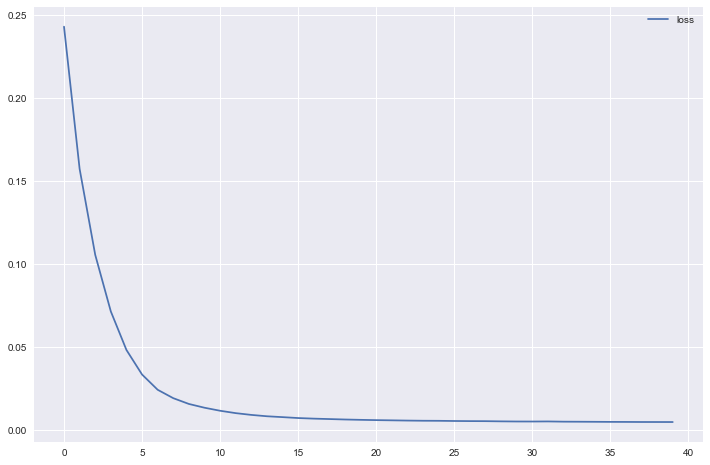

In [279]:
y_sc = sc.fit_transform(y)
es = EarlyStopping(monitor = 'loss', patience = 10, mode = 'min')

history = model.fit(X, y_sc, 
                    epochs = 40, 
                    batch_size = 32,
                    callbacks = [es],
                    verbose = 2)

plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label = 'loss')
plt.legend()
plt.show()


In [280]:
model.evaluate(X,y_sc)

768/768 [==============================] - 0s 77us/sample - loss: 0.0050 - acc: 0.9570


[0.005020954830494399, 0.95703125]

In [281]:
from sklearn.metrics import mean_squared_error
import math as m
prediction = model.predict(X)
print(f''' RMSE heating: {m.sqrt(mean_squared_error(features[:, 0], prediction[:, 0]))}''')
print(f''' RMSE cooling: {m.sqrt(mean_squared_error(features[:, 1], prediction[:, 1]))}''')

 RMSE heating: 0.30845438753859117
 RMSE cooling: 0.5186082492001748


### Integrated Stacking Neural Network

In [282]:
# constructing base modle
def fit_model(inputX, inputy):
    model = Sequential()
    model.add(Dense(10, input_dim = 8, activation = 'relu'))
    model.add(Dense(5, activation = 'relu'))
    model.add(Dense(2, activation = 'linear'))
    opt = Adam(lr = 0.001)
    
    model.compile(loss = 'mean_squared_error', optimizer = opt, metrics = ['accuracy'])
    model.fit(inputX, inputy, epochs = 50, batch_size = 32, verbose = 0)
    return model

In [265]:
from os import makedirs
makedirs('reg_models')

In [283]:
# saving models to directory
n_members = 5
for i in range(n_members):
    model = fit_model(X_train, y_train)
    filename = 'reg_models/model_' + str(i+1)
    model.save(filename)
    print(f''' > saved {filename}''')

 > saved reg_models/model_1
 > saved reg_models/model_2
 > saved reg_models/model_3
 > saved reg_models/model_4
 > saved reg_models/model_5


In [284]:
# loading model
from tensorflow.keras.models import load_model
def loading_model(n_models):
    all_models = list()
    for i in range(n_models):
        filename = 'reg_models/model_' + str(i+1)
        model = load_model(filename)
        all_models.append(model)
        print(f''' > loaded {filename}''')
    return all_models

In [285]:
all_models = loading_model(n_models = 5)

 > loaded reg_models/model_1
 > loaded reg_models/model_2
 > loaded reg_models/model_3
 > loaded reg_models/model_4
 > loaded reg_models/model_5


In [431]:
# define stacking model
from tensorflow.keras.layers import Input, concatenate
from tensorflow.keras.models import Model

def define_stacking_model(models):
    for i in range(len(models)):
        model = models[i]
        for layer in model.layers:
            # to preserve weight
            layer.trainable = False
            
    # define input
    ensemble_input = [model.input for model in models]
    # define output
    ensemble_output = [model.output for model in models]
    merge = concatenate(ensemble_output)
    # define layers
    hidden = Dense(32, activation = 'relu')(merge)
    hidden = Dense(8, activation = 'relu')(hidden)# using base model output as input for meta NN
    output = Dense(2, activation = 'linear')(hidden)
    
    #compile model
    model = Model(inputs = ensemble_input, outputs = output)
    opt = Adam(lr = 0.01)
    model.compile(loss = 'mean_squared_error', optimizer = opt, metrics = ['accuracy'])
    
    return model

In [432]:
from tensorflow.keras.utils import to_categorical 

def fit_stacking_model(model, inputX, inputy):
    X = [inputX for _ in range(len(model.input))] # input of each model from stacked model
    model.fit(X, inputy, epochs = 100, batch_size = 64, verbose = 0)

In [433]:
def predict_stacking_model(model, inputX):
    X = [inputX for _ in range(len(model.input))] # input of each model from fitted model
    pred = model.predict(X)
    return pred

In [434]:
stacked_model = define_stacking_model(all_models)

In [435]:
fit_stacking_model(stacked_model, X_test, y_test)

In [436]:
yhat = predict_stacking_model(stacked_model, X_test)
final_prediction = pd.DataFrame()
final_prediction['heating load prediction'] = np.expm1(yhat[:, 0])
final_prediction['cooling load prediction'] = np.expm1(yhat[:, 1])

final_prediction.head()

,heating load prediction,cooling load prediction
0,14.213203,17.734831
1,14.561985,17.892523
2,14.495424,18.259027
3,14.874223,18.910276
4,15.070138,18.968887


In [437]:
from sklearn.metrics import r2_score
heating_load_acc = r2_score(y_test[:,0], yhat[:,0])
cooling_load_acc = r2_score(y_test[:,1], yhat[:,1])

print(f''' heating load prediction accuracy: {heating_load_acc}''')
print(f''' cooling load prediction accuracy: {cooling_load_acc}''')

 heating load prediction accuracy: 0.9301149457797588
 cooling load prediction accuracy: 0.9154736482065055
